<a href="https://colab.research.google.com/github/vishwajeetfr/AdobeGensolve/blob/main/AdobeGensolve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install svgwrite cairosvg
!pip install bezier
!pip install numpy==1.23.0 scipy==1.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xgboost 2.1.1 requires nvidia-nccl-cu12; platform_system == "Linux" and platform_machine != "aarch64", which is not installed.
accelerate 0.32.1 requires numpy<2.0.0,>=1.17, but you have numpy 2.0.1 which

Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Other Shape Detected
Straight Line Detected


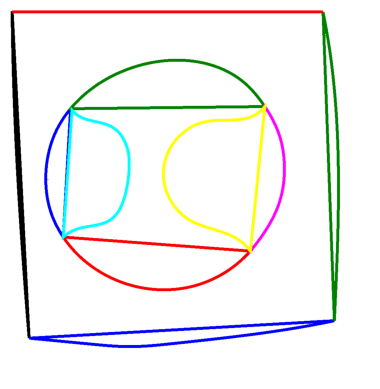

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import svgwrite
import cairosvg
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
import bezier
from bezier import Curve

# Step 1: Reading CSV Files
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Step 3: Regularizing Curves
def is_straight_line(points, tolerance=0.01):
    if len(points) < 2:
        return False
    reg = LinearRegression().fit(points[:, 0].reshape(-1, 1), points[:, 1])
    predicted = reg.predict(points[:, 0].reshape(-1, 1))
    error = np.abs(predicted - points[:, 1])
    return np.all(error < tolerance)

def is_circle(points, tolerance=0.01):
    if len(points) < 3:
        return False
    center = points.mean(axis=0)
    distances = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2)
    return np.all(np.abs(distances - distances.mean()) < tolerance)

def fit_circle(points):
    center = points.mean(axis=0)
    radius = np.sqrt((points[:, 0] - center[0])**2 + (points[:, 1] - center[1])**2).mean()
    theta = np.linspace(0, 2 * np.pi, 100)
    circle = np.vstack((center[0] + radius * np.cos(theta), center[1] + radius * np.sin(theta))).T
    return circle

def fit_line(points):
    reg = LinearRegression().fit(points[:, 0].reshape(-1, 1), points[:, 1])
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    x = np.linspace(x_min, x_max, 100)
    y = reg.predict(x.reshape(-1, 1))
    line = np.vstack((x, y)).T
    return line

def fit_spline(points):
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    unew = np.linspace(0, 1, 100)
    out = splev(unew, tck)
    spline = np.vstack((out[0], out[1])).T
    return spline

# New function: Determine if shape is a square or rectangle and fit accordingly
def is_quadrilateral(points, tolerance=0.01):
    if len(points) != 4:
        return False
    side_lengths = [distance.euclidean(points[i], points[(i+1) % 4]) for i in range(4)]
    return np.std(side_lengths) < tolerance

def fit_quadrilateral(points):
    side_lengths = [distance.euclidean(points[i], points[(i+1) % 4]) for i in range(4)]
    avg_length = np.mean(side_lengths)
    if np.std(side_lengths) / avg_length < 0.05:  # If side lengths are almost equal
        square_side = avg_length
        center = points.mean(axis=0)
        square = np.array([
            [center[0] - square_side / 2, center[1] - square_side / 2],
            [center[0] + square_side / 2, center[1] - square_side / 2],
            [center[0] + square_side / 2, center[1] + square_side / 2],
            [center[0] - square_side / 2, center[1] + square_side / 2],
        ])
        return square
    else:
        min_x, min_y = points.min(axis=0)
        max_x, max_y = points.max(axis=0)
        rectangle = np.array([
            [min_x, min_y],
            [max_x, min_y],
            [max_x, max_y],
            [min_x, max_y],
        ])
        return rectangle

# Step 5: Completing Incomplete Curves
def complete_curve(curve):
    if curve.shape[0] < 2:
        return curve  # Not enough points to complete
    distances = np.linalg.norm(curve[1:] - curve[:-1], axis=1)
    gap_threshold = np.mean(distances) * 2
    completed_curve = [curve[0]]
    for i in range(1, len(curve)):
        if distances[i-1] > gap_threshold:
            x_interp = np.linspace(curve[i-1, 0], curve[i, 0], num=100)
            y_interp = np.linspace(curve[i-1, 1], curve[i, 1], num=100)
            interpolated_points = np.vstack((x_interp, y_interp)).T
            completed_curve.extend(interpolated_points)
        else:
            completed_curve.append(curve[i])
    return np.array(completed_curve)

# Step 6: Outputting Results
def polylines2svg(paths_XYs, svg_path):
    W, H = 0, 0
    for path_XYs in paths_XYs:
        for XY in path_XYs:
            W, H = max(W, np.max(XY[:, 0])), max(H, np.max(XY[:, 1]))
    padding = 0.1
    W, H = int(W + padding * W), int(H + padding * H)
    dwg = svgwrite.Drawing(svg_path, profile='tiny', size=(W, H), shape_rendering='crispEdges')
    group = dwg.g()
    colours = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
    for i, path in enumerate(paths_XYs):
        path_data = []
        c = colours[i % len(colours)]
        for XY in path:
            path_data.append(("M", (XY[0, 0], XY[0, 1])))
            for j in range(1, len(XY)):
                path_data.append(("L", (XY[j, 0], XY[j, 1])))
            if not np.allclose(XY[0], XY[-1]):
                path_data.append(("Z", None))
        group.add(dwg.path(d=path_data, fill='none', stroke=c, stroke_width=2))
    dwg.add(group)
    dwg.save()
    png_path = svg_path.replace('.svg', '.png')
    fact = max(1, 1024 // min(H, W))
    cairosvg.svg2png(url=svg_path, write_to=png_path, parent_width=W, parent_height=H,
                     output_width=fact*W, output_height=fact*H, background_color='white')
    return png_path

# Main Function
def main():
    input_file = '/content/frag0.csv'  # Change this to your actual CSV input file path
    output_file = '/content/output.svg'  # Change this to your desired SVG output file path

    paths_XYs = read_csv(input_file)

    for path in paths_XYs:
        for i in range(len(path)):
            curve = path[i]
            if is_straight_line(curve):
                print("Straight Line Detected")
                path[i] = fit_line(curve)
            elif is_circle(curve):
                print("Circle Detected")
                path[i] = fit_circle(curve)
            elif is_quadrilateral(curve):
                print("Quadrilateral Detected")
                path[i] = fit_quadrilateral(curve)
            else:
                print("Other Shape Detected")
                path[i] = fit_spline(curve)

            path[i] = complete_curve(curve)

    png_path = polylines2svg(paths_XYs, output_file)

    # Display the final image
    img = plt.imread(png_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()
